# Implementing YOLOV2 from using Tensorflow 2.0


In this notebook I am going to re-implement YOLOV2 as described in the paper [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242). The goal is to replicate the model as described in the paper and train it on the [VOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset. 

## Introduction

Most of the code, in this notbook comes from a series of blog posts by Yumi. I just followed his posts to get things working. The original blog post uses Tensorflow 1.x so I had to change a few things to make it work but most of the code remains the same. I am linking all his blog posts here, and I highly recommend taking a look at it as it explains everything in much more detail.

### Yumi's Blog Posts with explanation

* [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)
* [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)
* [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html)
* [Part 4 Object Detection using YOLOv2 on Pascal VOC2012 - loss](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html)
* [Part 5 Object Detection using YOLOv2 on Pascal VOC2012 - training](https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html)
* [Part 6 Object Detection using YOLOv2 on Pascal VOC 2012 data - inference on image](https://fairyonice.github.io/Part_6_Object_Detection_with_Yolo_using_VOC_2012_data_inference_image.html)

### Google colab with end to end training and evaluation on VOC 2012

I followed Yumi's blogs to replicate YOLOV2 for VOC 2012 dataset. If you are looking for a consolidated python notebook with  everything working, you can clone this Google Colab notebook. 

https://colab.research.google.com/drive/14mPj3NYg_lJwWCRclzgPzdpKXoQutxUb?usp=sharing


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Preprocessing

I would be using [VOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset as its size is manageable so it would be easy to run it using Google Colab. 

First, I download and extract the dataset. 

In [3]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-06-13 07:06:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  12.0MB/s    in 2m 44s  

2022-06-13 07:08:50 (11.6 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [4]:
!tar xvf VOCtrainval_11-May-2012.tar

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC2012/Segmentati

Next, we define a function that parses the annotations from the XML files and stores it in an array. 

In [5]:
import os
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

We prepare the arrays with `training_image` and `seen_train_labels` for the whole dataset. 

As opposed to YOLOV1, YOLOV2 uses K-means clustering to find the best anchor box sizes for the given dataset. 

The `ANCHORS` defined below are taken from the following blog: 

[Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html).

Instead of rerunning the K-means algorithm again, we use the `ANCHORS` obtained by [Yumi](https://fairyonice.github.io/) as it is.  
 

In [6]:
import numpy as np
## Parse annotations 
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


Next, we define a `ImageReader` class to process an image. It takes in an image and returns the resized image and all the objects in the image. 

In [7]:
import copy
import cv2 

class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        
        '''
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        h, w, c = image.shape
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

Here's a sample usage of the `ImageReader` class. 

******************************
Input
  object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
  filename: VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg
  width: 486
  height: 500
******************************
Output
          [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]


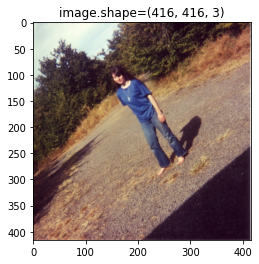

In [8]:
def normalize(image):
    return image / 255.

print("*"*30)
print("Input")
timage = train_image[0]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("          {}".format(all_objs))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

Next, we define `BestAnchorBoxFinder` which finds the best anchor box for a particular object. This is done by finding the anchor box with the highest IOU(Intersection over Union) with the bounding box of the object. 

In [9]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence      = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])

Here's a sample usage of the `BestAnchorBoxFinder` class. 

In [10]:
# Anchor box width and height found in https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])
print(".."*40)
print("The three example anchor boxes:")
count = 0
for i in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[i],_ANCHORS01[i+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2):
        h /= 10.
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(
            w,h,best_anchor,max_iou))

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3

In [11]:
def rescale_centerxy(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_cebterwh(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''    
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

In [12]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}
center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_cebterwh(obj,config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


Next, we define a custom Batch generator to get a batch of 16 images and its corresponding bounding boxes.

In [13]:
from tensorflow.keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 416, 
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,  
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

In [14]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [15]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [16]:
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
check_object_in_grid_anchor_pair(iframe)

igrid_h=08,igrid_w=06,iAnchor=03, person


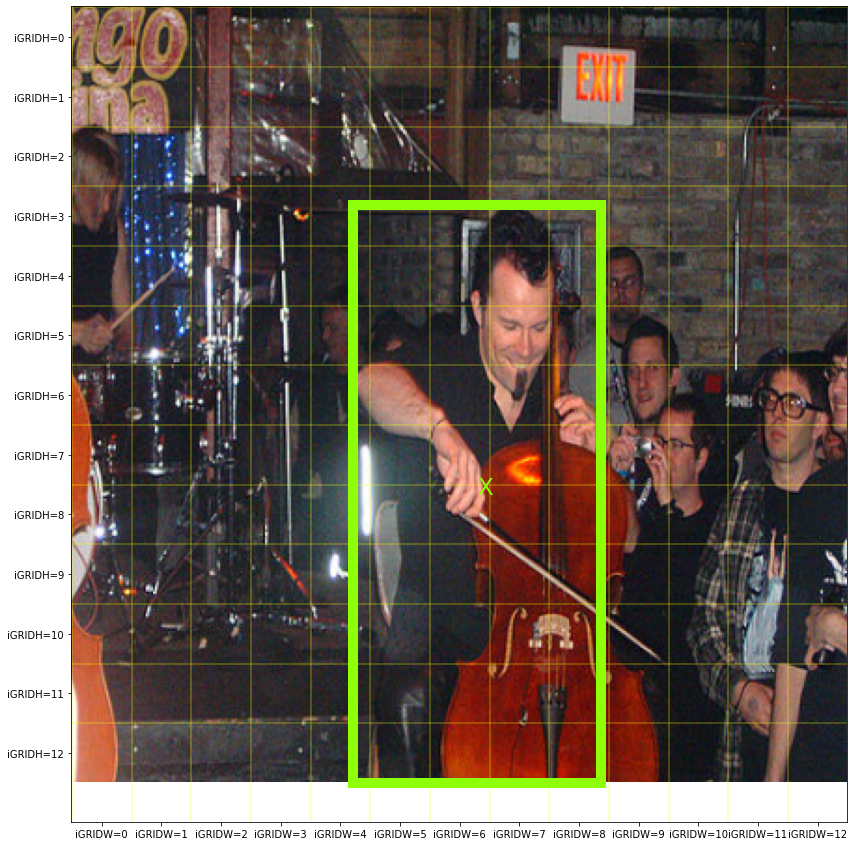

In [17]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

In [ ]:
for irow in range(5, 10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()

Next, I am adding a function to prepare the input and the output. The input is a (448, 448, 3) image and the output is a (7, 7, 30) tensor. The output is based on S x S x (B * 5 +C). 

S X S is the number of grids
B is the number of bounding boxes per grid
C is the number of predictions per grid

## Training the model

Next, I am defining a custom generator that returns a batch of input and outputs. 

Next, we create instances of the generator for our training and validation sets. 

### Define a custom output layer

We need to reshape the output from the model so we define a custom Keras layer for it. 

### Defining the YOLO model. 

Next, we define the model as described in the original paper. 

![YOLO V2](https://www.maskaravivek.com/img/YOLOV2.png)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 416, 416, 32  128         ['conv_1[0][0]']                 
                                )                                                             

Next, we download the pre-trained weights for YOLO V2. 

In [ ]:
!wget https://pjreddie.com/media/files/yolov2.weights

In [ ]:
path_to_weight = "./yolov2.weights"

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
                
weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

In [ ]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [ ]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

### Define a custom learning rate scheduler

The paper uses different learning rates for different epochs. So we define a custom Callback function for the learning rate. 

In [ ]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

### Define the loss function

Next, we would be defining a custom loss function to be used in the model. Take a look at this blog post to understand more about the [loss function used in YOLO](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html). 

I understood the loss function but didn't implement it on my own. I took the implementation as it is from the above [blog post](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html). 

The original blog post was using Tensorflow 1.x so I had to update some of the code to make it run it on Tensorflow 2.x. 

In [ ]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [ ]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 

In [ ]:
def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of 
    
    ### adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)

In [ ]:
def print_min_max(vec,title):
  try:
    print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))
  except ValueError:  #raised if `y` is empty.
      pass

In [ ]:
print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 

print("\npred_box_xy {}".format(pred_box_xy.shape)) 

for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0],
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1],
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf,"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class,"  class probability") 

We extract the ground truth. 

In [ ]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [ ]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0]
    pick = true_box_conf[:,:,igrid_w,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1]
    pick = true_box_conf[:,igrid_h,:,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class)) )

In [ ]:
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh): 
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * LAMBDA_COORD 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord_mask)

In [ ]:
LAMBDA_COORD = 1
loss_xywh, coord_mask  = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy,true_box_wh, pred_box_wh)

print("*"*30 + "\nouput\n" + "*"*30)

print("loss_xywh = {:4.3f}".format(loss_xywh))

In [ ]:
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)

In [ ]:
LAMBDA_CLASS   = 1
loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                 true_box_class,pred_box_class)
print("*"*30 + "\nouput\n" + "*"*30) 
print("loss_class = {:4.3f}".format(loss_class))

In [ ]:
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)

In [ ]:
true_box_conf_IOU = calc_IOU_pred_true_assigned(
                            true_box_conf,
                            true_box_xy, true_box_wh,
                            pred_box_xy,  pred_box_wh)

print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_conf = {}".format(true_box_conf))
print("true_box_xy   = {}".format(true_box_xy))
print("true_box_wh   = {}".format(true_box_wh))
print("pred_box_xy   = {}".format(pred_box_xy))
print("pred_box_wh   = {}".format(pred_box_wh))
print("*"*30 + "\nouput\n" + "*"*30) 
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))
vec  = true_box_conf_IOU
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

In [ ]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)

In [ ]:
true_boxes = tf.constant(b_batch,dtype="float32")
best_ious = calc_IOU_pred_true_best(pred_box_xy,
                                       pred_box_wh,
                                       true_boxes)
    
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_wh   = {}".format(true_box_wh))
print("pred_box_xy   = {}".format(pred_box_xy))
print("pred_box_wh   = {}".format(pred_box_wh))
print("*"*30 + "\nouput\n" + "*"*30) 
print("best_ious.shape = {}".format(best_ious.shape))
vec  = best_ious
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero best_ious")
plt.show()

In [ ]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

In [ ]:
conf_mask = get_conf_mask(best_ious, 
                             true_box_conf, 
                             true_box_conf_IOU,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)
print("*"*30 + "\ninput\n" + "*"*30)  
print("best_ious         = {}".format(best_ious)) 
print("true_box_conf     = {}".format(true_box_conf))
print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
print("LAMBDA_NO_OBJECT  = {}".format(LAMBDA_NO_OBJECT)) 
print("LAMBDA_OBJECT     = {}".format(LAMBDA_OBJECT))

print("*"*30 + "\noutput\n" + "*"*30)      
print("conf_mask shape = {}".format(conf_mask.shape))

In [ ]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

In [ ]:
print("*"*30 + "\ninput\n" + "*"*30)  
print("conf_mask         = {}".format(conf_mask)) 
print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
print("pred_box_conf     = {}".format(pred_box_conf))

loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    
print("*"*30 + "\noutput\n" + "*"*30)      
print("loss_conf = {:5.4f}".format(loss_conf))

In [ ]:
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
        
    '''
    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss


In [ ]:
print(y_batch.dtype, y_pred.dtype)
true_boxes = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32')) 
print('loss', loss)

### Add a callback for saving the weights

Next, I define a callback to keep saving the best weights. 

### Compile the model

Finally, I compile the model using the custom loss function that was defined above. 

In [ ]:
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


generator_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/cv_data/yolo_v2/weights_yolo_on_voc2012.h5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=custom_loss ,optimizer=optimizer)

### Train the model

Now that we have everything setup, we will call `model.fit` to train the model for 135 epochs. 

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

model.fit_generator(generator        = train_batch_generator, 
                    steps_per_epoch  = len(train_batch_generator), 
                    epochs           = 10, 
                    verbose          = 1,
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

## Evaluation

Now, that we have trained our model, lets use it to predict the class labels and bounding boxes for a few images. 

Lets pass an image and see the prediction for the image. 

In [ ]:
imageReader = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
out = imageReader.fit(train_image_folder + "/2007_005430.jpg")

In [ ]:
print(out.shape)
X_test = np.expand_dims(out,0)
print(X_test.shape)
# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])
print(y_pred.shape)

Note, that the `y_pred` needs to be scaled up. So we define a class called `OutputRescaler` for it. 

In [ ]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

Let's try out the `OutputRescaler` class.

In [ ]:
netout         = y_pred[0]
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)

Also, lets define a method to find bounding boxes with high confidence probability.

In [ ]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)

Let's try out the above function and see if it works. 

In [ ]:
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

Also, next we define a function to draw bounding boxes on the image. 

In [ ]:
import cv2, copy
import seaborn as sns
def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=color, 
                      thickness=sr)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)
        
    return image


print("Plot with low object threshold")
ima = draw_boxes(X_test[0],boxes_tiny_threshold,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0],boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with high object threshold")
plt.show()

Notice, that each object has multiple bounding boxes around it. So we define a function to apply non max suppression that chooes the bounding box with the highest IOU. 

In [ ]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
                        
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]                
    
    return newboxes

Lets use the above function to see if it reduces the number of bounding boxes. 

In [ ]:
iou_threshold = 0.01
final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=obj_threshold)
print("{} final number of boxes".format(len(final_boxes)))

5 final number of boxes


bicycle    0.574 xmin=  85,ymin= 138,xmax= 222,ymax= 276
bicycle    0.574 xmin=  85,ymin= 138,xmax= 222,ymax= 276
bicycle    0.574 xmin=  85,ymin= 138,xmax= 222,ymax= 276
bicycle    0.574 xmin=  85,ymin= 138,xmax= 222,ymax= 276
person     0.691 xmin= 175,ymin=  27,xmax= 295,ymax= 303


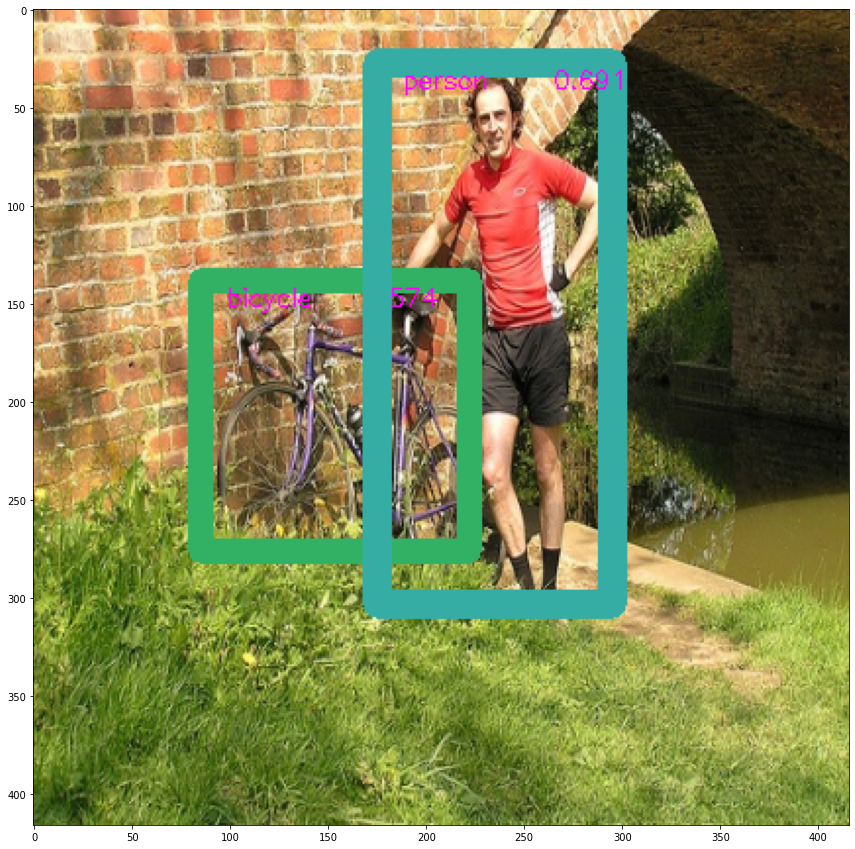

In [ ]:
ima = draw_boxes(X_test[0],final_boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()

Next, lets have some fun by evaluating more images and see the results. 

In [ ]:
np.random.seed(1)
Nsample   = 2
image_nms = list(np.random.choice(os.listdir(train_image_folder),Nsample))

In [ ]:
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
imageReader    = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
X_test         = []
for img_nm in image_nms:
    _path    = os.path.join(train_image_folder,img_nm)
    out      = imageReader.fit(_path)
    X_test.append(out)

X_test = np.array(X_test)

## model
dummy_array    = np.zeros((len(X_test),1,1,1,TRUE_BOX_BUFFER,4))
y_pred         = model.predict([X_test,dummy_array])

for iframe in range(len(y_pred)):
        netout         = y_pred[iframe] 
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,
                                                iou_threshold=iou_threshold,
                                                obj_threshold=obj_threshold)
            ima = draw_boxes(X_test[iframe],final_boxes,LABELS,verbose=True)
            plt.figure(figsize=figsize)
            plt.imshow(ima); 
            plt.show()

## Conclusion

It was a good exercise to implement YOLO V2 from scratch and understand various nuances of writing a model from scratch. This implementation won't achieve the same accuracy as what was described in the paper since we have skipped the pretraining step. 